In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
import skimage
from skimage import io,color,img_as_ubyte
import cv2
import os
from itertools import permutations
from itertools import combinations_with_replacement
import mahotas
from skimage.feature import graycomatrix,graycoprops
import datetime
from patchify import patchify

C:\Users\LENOVO\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
from sklearn.cluster import KMeans
from PIL import Image

In [62]:
# !pip install patchify

  Obtaining dependency information for patchify from https://files.pythonhosted.org/packages/00/ce/d76647d95aad98d5532b5d25801dedda788c6b5d4c7457d30ae3612132af/patchify-0.2.3-py3-none-any.whl.metadata


In [188]:

def ExtractFeature(img, patch_size,stride,GLCM_bin_size):
    diss_sim = []
    corr = []
    homogen = []
    energy = []
    contrast = []
    uniformity=[]
    
# creating patches
    patches= patchify(img,patch_size,stride)
    patches= np.int8(patches*(GLCM_bin_size-1))
    no_of_patches=len(patches)
    for i in range(no_of_patches):
        for j in range(no_of_patches):
            glcm = graycomatrix(patches[i][j], distances=[1], angles=[0], levels=GLCM_bin_size,
                                    symmetric=True, normed=True)
            diss_sim.append(graycoprops(glcm, 'dissimilarity',)[0, 0]) #[0,0] to convert array to value
            corr.append(graycoprops(glcm, 'correlation')[0, 0])
            homogen.append(graycoprops(glcm, 'homogeneity')[0, 0])
            energy.append(graycoprops(glcm, 'energy')[0, 0])
            contrast.append(graycoprops(glcm, 'contrast')[0, 0])
            uniformity.append(graycoprops(glcm,'ASM')[0,0]) 
            

    return diss_sim,corr,homogen,energy,contrast,uniformity


In [4]:
def CentreCoord(img,patch_size):
    size_of_img=img.shape[0]
    first_pt=patch_size//2+1
    last_pt=(size_of_img)-(patch_size//2)+2   
    number=np.arange(first_pt,last_pt)
    
    centre_coords1= list(permutations(number,2))
    centre_coords2= list(combinations_with_replacement(number,2))
    centre_coords= sorted(set(centre_coords1+centre_coords2))
    
    return centre_coords

In [230]:
def Colouring(blank,df,patch_size,pixels,clusters): 
    cluster_labels=np.arange(0,clusters)
    colours=[(255,0,0),(0,255,0),(0,0,255),(0,255,255),(255,0,255),(255,255,0),(0,102,0),(102,0,0),(0,102,102),(204,153,255)]
    centre_itr=iter(pixels)
    
    for i in range(len(df)-1):
        for j in range(len(cluster_labels)):
            
            if df['labels'][i]==cluster_labels[j]:
                blank[next(centre_itr)]=colours[j]

    coloured_img=blank
    
    return coloured_img

In [226]:
# def Colouring(blank,df,patch_size,pixels,clusters): 
#     cluster_labels=np.arange(0,clusters)
#     centre_itr=iter(pixels)
    
#     for i in range(len(df)-1):
#         if df['labels'][i]==cluster_labels[0]:
#             blank[next(centre_itr)]=(255,0,0)

#         elif df['labels'][i]==cluster_labels[1]:
#             blank[next(centre_itr)]=(0,255,0)

#         elif df['labels'][i]==cluster_labels[2]:
#             blank[next(centre_itr)]=(0,0,255)
            
#         elif df['labels'][i]==cluster_labels[3]:
#             blank[next(centre_itr)]=(0,255,255)
            
#         elif df['labels'][i]==cluster_labels[4]:
#             blank[next(centre_itr)]=(255,0,255)
            
#         elif df['labels'][i]==cluster_labels[5]:
#             blank[next(centre_itr)]=(255,255,0)
            
#         elif df['labels'][i]==cluster_labels[6]:
#             blank[next(centre_itr)]=(0,102,0)
            
#         elif df['labels'][i]==cluster_labels[7]:
#             blank[next(centre_itr)]=(102,0,0)
            
#         elif df['labels'][i]==cluster_labels[8]:
#             blank[next(centre_itr)]=(0,102,102)

#         else:
#             blank[next(centre_itr)]=(204,153,255)
            
#     coloured_img=blank
    
#     return coloured_img

In [239]:

def pipeline(img,patch_size,stride,GLCM_bin_size,n_clusters):
    #blank image
    blank=np.zeros([img.shape[0],img.shape[0],3],dtype='float')
    
    t1=datetime.datetime.now()
    
#     extracting patches
    data=ExtractFeature(img,patch_size,stride,GLCM_bin_size)
    
    
#     storing features in dataframe
    data={'diss_sim':data[0],'corr':data[1],'homogen':data[2],
         'energy':data[3],'contrast':data[4],
         'uniformity':data[5]}    
    df=pd.DataFrame(data)
    
#     kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0) 
    kmeans.fit(df)
    labels= kmeans.labels_
    df['labels']=labels 
    
#     fetching the centre pixels of patches
    centre=CentreCoord(img,patch_size)
#     colouring blank image
    coloured_img=Colouring(blank,df,patch_size,centre,n_clusters)
    
    t2=datetime.datetime.now()
    print(f"Time taken for Patch_size:{patch_size},Stride:{stride},Bin_size:{255/GLCM_bin_size}---", t2-t1)
    
    return coloured_img

In [97]:
os.getcwd()

'C:\\Texture_detection\\Texture_detection\\collages'

In [ ]:
# os.chdir(r"")

In [190]:
image=io.imread('0-1-2-3.jpg')
gray=color.rgb2gray(image)
# print(gray.shape)

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken for Patch_size:50,Stride:1,Bin_size:10.2--- 0:00:12.931302


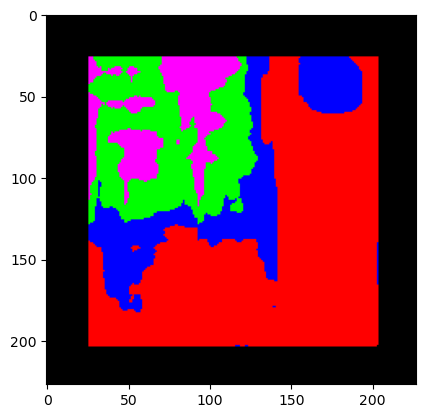

In [195]:
plt.imshow(pipeline(gray2,50,1,25))

In [53]:
os.getcwd()
os.listdir('../')

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '0-1-2-3.jpg',
 'app.py',
 'Brodatz Texture',
 'collages',
 'LICENSE',
 'logs',
 'README.md',
 'requirements.txt',
 'research',
 'setup.py',
 'src',
 'template.py',
 'test.ipynb',
 'test.py']

In [55]:
img_path=r"C:\Texture_detection\Texture_detection\Brodatz Texture"

In [54]:
collage_path=r"C:\Texture_detection\Texture_detection\collages"

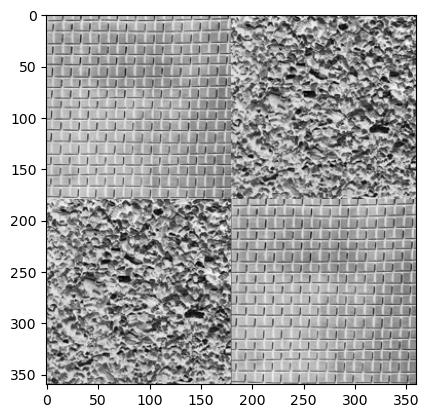

In [101]:
img1 = Image.open(os.path.join(img_path,"0.gif"))
img2 = Image.open(os.path.join(img_path,"1.gif"))
img3 = Image.open(os.path.join(img_path,"2.gif"))
img4 = Image.open(os.path.join(img_path,"3.gif"))

img1_size = img1.resize((180,180)) 
img2_size = img2.resize((180,180)) 
img3_size = img3.resize((180,180))
img4_size = img4.resize((180,180))

# creating a new image and pasting the 
# images 
white_image = Image.new('L',(360, 360), "white") 

# pasting the first image 
white_image.paste(img1_size,(0, 0)) 

# pasting the second image
white_image.paste(img2_size,(180, 0))
                  
# pasting the third image
white_image.paste(img3_size,(0, 180))
                  
# pasting the fourth image
white_image.paste(img4_size,(180, 180))

white_image.save(f'collage2.jpg',)

plt.imshow(white_image,cmap='gray') 

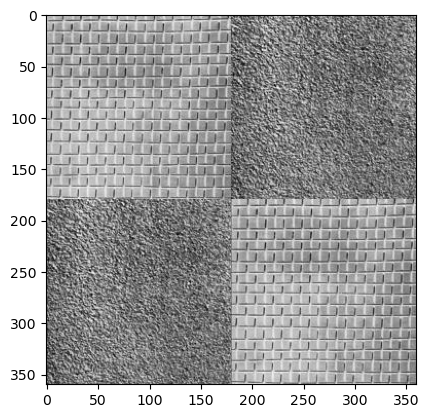

In [202]:
image3=io.imread('collage1.jpg')
image3=color.gray2rgb(image3)
gray3=color.rgb2gray(image3)
plt.imshow(gray3,cmap='gray')

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken for Patch_size:10,Stride:1,Bin_size:12.75--- 0:00:46.625957


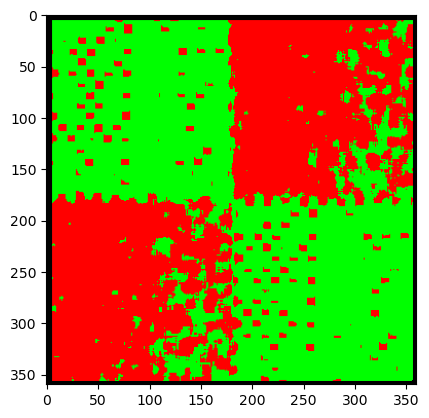

In [263]:
coloured3=plt.imshow(pipeline(gray3,10,1,20,2))

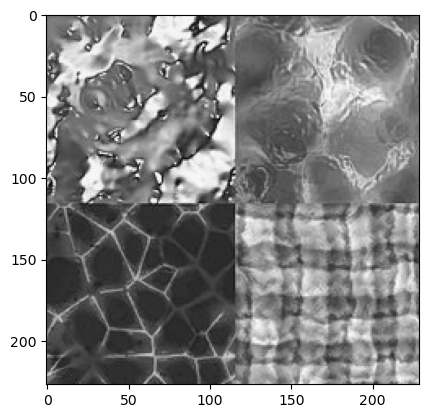

In [194]:
image2=io.imread('Tiling_procedural_textures.jpg')
gray2=color.rgb2gray(image2)
plt.imshow(gray2,cmap='gray')

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken for Patch_size:10,Stride:1,Bin_size:12.75--- 0:00:18.651803


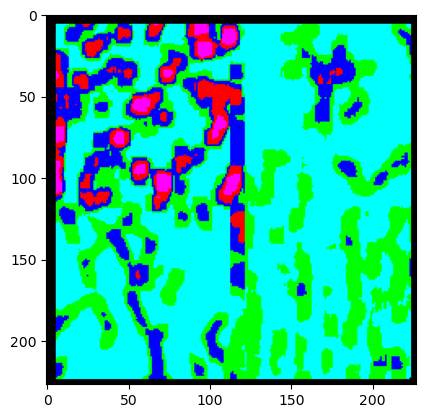

In [265]:
plt.imshow(pipeline(gray2,10,1,20,5))

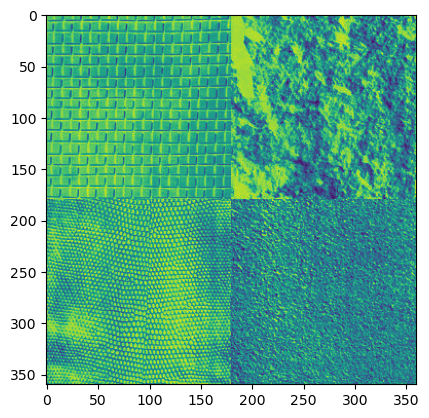

In [237]:
plt.imshow(gray)

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken for Patch_size:41,Stride:1,Bin_size:12.75--- 0:00:43.424596


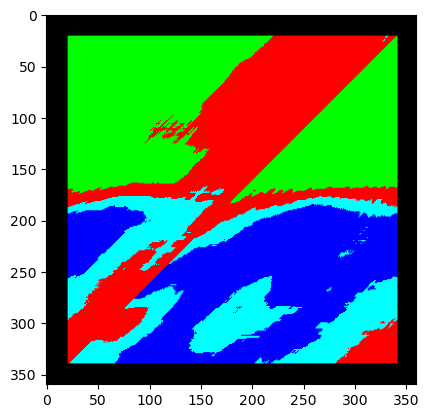

In [269]:
plt.imshow(pipeline(gray,41,1,20,4))

In [244]:
gray

array([[0.50196078, 0.74117647, 0.73333333, ..., 0.51372549, 0.5372549 ,
        0.66666667],
       [0.52941176, 0.76078431, 0.7372549 , ..., 0.58823529, 0.74509804,
        0.78823529],
       [0.47843137, 0.7372549 , 0.74509804, ..., 0.50588235, 0.8627451 ,
        0.87843137],
       ...,
       [0.85882353, 0.76078431, 0.69019608, ..., 0.43529412, 0.54509804,
        0.58431373],
       [0.70196078, 0.48627451, 0.53333333, ..., 0.28235294, 0.37254902,
        0.4745098 ],
       [0.50196078, 0.25490196, 0.4745098 , ..., 0.45490196, 0.60784314,
        0.61568627]])

In [245]:
file_bytes= np.asarray(bytearray(gray),dtype=np.uint8)

In [246]:
file_bytes

array([ 16,  16,  16, ..., 179, 227,  63], dtype=uint8)

In [251]:
min(np.asarray(bytearray(gray)))

0

In [252]:
np.asarray(bytearray(gray)).shape

(1036800,)

In [255]:
360*360*8

1036800

In [257]:
img.shape

(360, 360, 3)

In [256]:
gray

array([[0.50196078, 0.74117647, 0.73333333, ..., 0.51372549, 0.5372549 ,
        0.66666667],
       [0.52941176, 0.76078431, 0.7372549 , ..., 0.58823529, 0.74509804,
        0.78823529],
       [0.47843137, 0.7372549 , 0.74509804, ..., 0.50588235, 0.8627451 ,
        0.87843137],
       ...,
       [0.85882353, 0.76078431, 0.69019608, ..., 0.43529412, 0.54509804,
        0.58431373],
       [0.70196078, 0.48627451, 0.53333333, ..., 0.28235294, 0.37254902,
        0.4745098 ],
       [0.50196078, 0.25490196, 0.4745098 , ..., 0.45490196, 0.60784314,
        0.61568627]])

In [259]:
color.rgb2gray(img)

array([[0.49411765, 0.76470588, 0.74117647, ..., 0.20784314, 0.17254902,
        0.27058824],
       [0.50196078, 0.76078431, 0.73333333, ..., 0.25098039, 0.21568627,
        0.2745098 ],
       [0.51372549, 0.76078431, 0.73333333, ..., 0.42352941, 0.15686275,
        0.26666667],
       ...,
       [0.68627451, 0.78823529, 0.50980392, ..., 0.56862745, 0.54901961,
        0.56862745],
       [0.78823529, 0.81960784, 0.71372549, ..., 0.43137255, 0.42745098,
        0.46666667],
       [0.80784314, 0.64313725, 0.41176471, ..., 0.45490196, 0.44705882,
        0.40392157]])

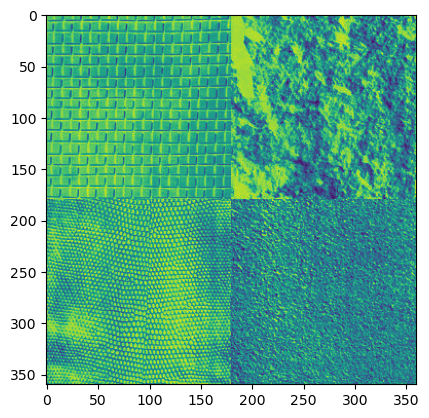

In [260]:
plt.imshow(gray)

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken for Patch_size:21,Stride:1,Bin_size:10.2--- 0:00:49.388149


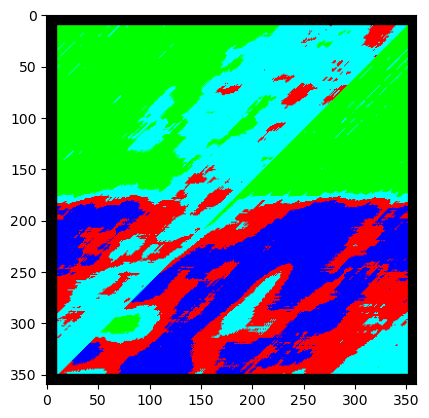

In [262]:
coloured=plt.imshow(pipeline(gray,21,1,25,4))

In [271]:
np.clip(np.arange(0,100,1),1,10)

array([ 1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])